# MMLU Evaluation


In [1]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [2]:
import pandas as pd
from datasets import load_dataset

# Load MMLU high_school_physics dataset from HuggingFace
# This will download and properly load the parquet files
print("Loading MMLU high_school_physics dataset...")
mmlu_dataset = load_dataset("cais/mmlu", "high_school_physics")


/Users/pmui/SynologyDrive/research/2025/research2025/13-langchain/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading MMLU high_school_physics dataset...


In [3]:
# Convert to pandas DataFrames
test_df = mmlu_dataset['test'].to_pandas()
validation_df = mmlu_dataset['validation'].to_pandas()
dev_df = mmlu_dataset['dev'].to_pandas()


In [4]:
# Display basic info
print("Test set shape:", test_df.shape)
print("Validation set shape:", validation_df.shape)
print("Dev set shape:", dev_df.shape)
print("\nTest set columns:", test_df.columns.tolist())
print("\nFirst few rows of test set:")
test_df.head()

Test set shape: (151, 4)
Validation set shape: (17, 4)
Dev set shape: (5, 4)

Test set columns: ['question', 'subject', 'choices', 'answer']

First few rows of test set:


,question,subject,choices,answer
0,The plates of a capacitor are charged to a pot...,high_school_physics,"[0.005 C, 0.01 C, 0.02 C, 0.5 C]",1
1,Which of these quantities decreases as the inv...,high_school_physics,[the electric field produced by a finite-lengt...,0
2,"A solid, metal object is isolated from other c...",high_school_physics,"[electric field outside the object is zero, th...",3
3,Standing waves are produced by a 100-Hz genera...,high_school_physics,"[Less, because the tension in the string varie...",2
4,Two identical capacitors are hooked in paralle...,high_school_physics,"[I only, II only, II and III only, (E) I, II, ...",3


In [5]:
print(f"question: {test_df.iloc[0]['question']}")
print(f"answer: {test_df.iloc[0]['answer']}")
print(f"options: {test_df.iloc[0]['choices']}")


question: The plates of a capacitor are charged to a potential difference of 5 V. If the capacitance is 2 mF, what is the charge on the positive plate?
answer: 1
options: ['0.005 C' '0.01 C' '0.02 C' '0.5 C']


## Langchain agent for Physics


In [6]:
from langchain.agents import create_agent

### Nano Agent: `gpt-5-nano`


In [7]:
%%time

nano_agent = create_agent(
    model="openai:gpt-5-nano",
    tools=[],
    system_prompt=(
        "You are an agent that can answer questions about physics. "
        "You are given a list of options, and you need to select the correct answer's index from the list. "
        "Your response should be a single number, which is the index of the correct answer in the provided list. "
    )
)

def get_agent_response(question: str, choices: list[str]) -> str:
    evaluation_content = f"Question: {question}\nOptions: {choices}"
    response = nano_agent.invoke(
        {"messages": [{"role": "user", "content": evaluation_content}]}
    )
    return response["messages"][-1].content

total_correct = 0
MAX_QUESTIONS = 5
for index, row in test_df.iloc[:MAX_QUESTIONS].iterrows():
    question = row['question']

    response = get_agent_response(question, row['choices'])
    print(f"answer: {row['answer']} <=> {response}")
    if int(response) == row['answer']:
        total_correct += 1

print(f"nano %correct: {float(total_correct)/MAX_QUESTIONS:.2f}")


answer: 1 <=> 1
answer: 0 <=> 0
answer: 3 <=> 4
answer: 2 <=> 2
answer: 3 <=> 4
nano %correct: 0.60
CPU times: user 377 ms, sys: 111 ms, total: 489 ms
Wall time: 39.9 s


In [8]:
%%time

MAX_QUESTIONS = 50
MAX_WORKERS = 10

nano_agent = create_agent(
    model="openai:gpt-5-nano",
    tools=[],
    system_prompt=(
        "You are an agent that can answer questions about physics. "
        "You are given a list of options, and you need to select the correct answer's index from the list. "
        "Your response should be a single number, which is the index of the correct answer in the provided list. "
    )
)

def get_nano_response(question: str, choices: list[str]) -> str:
    evaluation_content = f"Question: {question}\nOptions: {choices}"
    response = nano_agent.invoke(
        {"messages": [{"role": "user", "content": evaluation_content}]}
    )
    return response["messages"][-1].content

from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row(row):
    """Process a single row and return (index, answer, response)"""
    question = row['question']
    response = get_nano_response(question, row['choices'])
    return (row.name, row['answer'], response)

total_correct = 0
# Process rows in parallel with max 10 concurrent calls
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all tasks
    futures = {executor.submit(process_row, row): row for _, row in test_df.iloc[:MAX_QUESTIONS].iterrows()}
    
    # Process results as they complete
    for future in as_completed(futures):
        index, answer, response = future.result()
        print(f"answer: {answer} <=> {response}")
        if int(response) == answer:
            total_correct += 1

print(f"nano %correct: {float(total_correct)/MAX_QUESTIONS:.2f}")

answer: 0 <=> 0
answer: 1 <=> 2
answer: 0 <=> 0
answer: 3 <=> 4
answer: 3 <=> 4
answer: 2 <=> 2
answer: 1 <=> 2
answer: 1 <=> 2
answer: 0 <=> 1
answer: 3 <=> 3
answer: 2 <=> 2
answer: 2 <=> 3
answer: 1 <=> 1
answer: 3 <=> 4
answer: 2 <=> 2
answer: 2 <=> 2
answer: 0 <=> 0
answer: 3 <=> 3
answer: 3 <=> 3
answer: 0 <=> 0
answer: 2 <=> 2
answer: 1 <=> 1
answer: 3 <=> 3
answer: 3 <=> 3
answer: 2 <=> 2
answer: 3 <=> 3
answer: 3 <=> 2
answer: 1 <=> 2
answer: 0 <=> 0
answer: 1 <=> 1
answer: 2 <=> 2
answer: 2 <=> 2
answer: 2 <=> 3
answer: 3 <=> 3
answer: 0 <=> 0
answer: 3 <=> 3
answer: 2 <=> 2
answer: 2 <=> 2
answer: 2 <=> 2
answer: 0 <=> 0
answer: 1 <=> 1
answer: 2 <=> 2
answer: 2 <=> 2
answer: 1 <=> 2
answer: 2 <=> 0
answer: 3 <=> 3
answer: 1 <=> 1
answer: 3 <=> 3
answer: 3 <=> 0
answer: 0 <=> 0
nano %correct: 0.72
CPU times: user 593 ms, sys: 139 ms, total: 732 ms
Wall time: 1min 15s


### Mini Agent: `gpt-5-mini`


In [10]:
%%time

MAX_QUESTIONS = 50
MAX_WORKERS = 10

mini_agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[],
    system_prompt=(
        "You are an agent that can answer questions about physics. "
        "You are given a list of options, and you need to select the correct answer's index from the list. "
        "Your response should be a single number, which is the index of the correct answer in the provided list. "
    )
)

def get_agent_response(question: str, choices: list[str]) -> str:
    evaluation_content = f"Question: {question}\nOptions: {choices}"
    response = mini_agent.invoke(
        {"messages": [{"role": "user", "content": evaluation_content}]}
    )
    return response["messages"][-1].content

from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row(row):
    """Process a single row and return (index, answer, response)"""
    question = row['question']
    response = get_agent_response(question, row['choices'])
    return (row.name, row['answer'], response)

total_correct = 0
# Process rows in parallel with max 10 concurrent calls
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all tasks
    futures = {executor.submit(process_row, row): row for _, row in test_df.iloc[:MAX_QUESTIONS].iterrows()}
    
    # Process results as they complete
    for future in as_completed(futures):
        index, answer, response = future.result()
        print(f"answer: {answer} <=> {response}")
        if int(response) == answer:
            total_correct += 1

print(f"mini %correct: {float(total_correct)/MAX_QUESTIONS:.2f}")

answer: 2 <=> 3
answer: 1 <=> 2
answer: 3 <=> 3
answer: 3 <=> 3
answer: 2 <=> 2
answer: 0 <=> 0
answer: 1 <=> 1
answer: 0 <=> 0
answer: 2 <=> 2
answer: 0 <=> 0
answer: 1 <=> 2
answer: 1 <=> 1
answer: 2 <=> 2
answer: 3 <=> 3
answer: 0 <=> 1
answer: 3 <=> 4
answer: 3 <=> 3
answer: 3 <=> 4
answer: 3 <=> 2
answer: 1 <=> 1
answer: 0 <=> 0
answer: 2 <=> 2
answer: 0 <=> 0
answer: 2 <=> 2
answer: 2 <=> 2
answer: 3 <=> 3
answer: 3 <=> 4
answer: 2 <=> 3
answer: 3 <=> 2
answer: 3 <=> 4
answer: 2 <=> 3
answer: 0 <=> 0
answer: 0 <=> 1
answer: 3 <=> 3
answer: 1 <=> 1
answer: 2 <=> 2
answer: 1 <=> 1
answer: 2 <=> 2
answer: 2 <=> 2
answer: 2 <=> 3
answer: 2 <=> 2
answer: 1 <=> 1
answer: 3 <=> 4
answer: 3 <=> 3
answer: 2 <=> 0
answer: 1 <=> 1
answer: 1 <=> 1
answer: 2 <=> 2
answer: 0 <=> 0
answer: 3 <=> 4
mini %correct: 0.66
CPU times: user 548 ms, sys: 119 ms, total: 667 ms
Wall time: 49.7 s


### Full Agent: `gpt-5`


In [11]:
%%time

MAX_QUESTIONS = 50
MAX_WORKERS = 10

full_agent = create_agent(
    model="openai:gpt-5",
    tools=[],
    system_prompt=(
        "You are an agent that can answer questions about physics. "
        "You are given a list of options, and you need to select the correct answer's index from the list. "
        "Your response should be a single number, which is the index of the correct answer in the provided list. "
    )
)

def get_agent_response(question: str, choices: list[str]) -> str:
    evaluation_content = f"Question: {question}\nOptions: {choices}"
    response = full_agent.invoke(
        {"messages": [{"role": "user", "content": evaluation_content}]}
    )
    return response["messages"][-1].content

from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row(row):
    """Process a single row and return (index, answer, response)"""
    question = row['question']
    response = get_agent_response(question, row['choices'])
    return (row.name, row['answer'], response)

total_correct = 0
# Process rows in parallel with max 10 concurrent calls
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all tasks
    futures = {executor.submit(process_row, row): row for _, row in test_df.iloc[:MAX_QUESTIONS].iterrows()}
    
    # Process results as they complete
    for future in as_completed(futures):
        index, answer, response = future.result()
        print(f"answer: {answer} <=> {response}")
        if int(response) == answer:
            total_correct += 1

print(f"full %correct: {float(total_correct)/MAX_QUESTIONS:.2f}")

answer: 1 <=> 1
answer: 1 <=> 1
answer: 2 <=> 2
answer: 0 <=> 0
answer: 0 <=> 0
answer: 3 <=> 3
answer: 3 <=> 3
answer: 2 <=> 2
answer: 2 <=> 2
answer: 1 <=> 1
answer: 1 <=> 1
answer: 0 <=> 1
answer: 3 <=> 3
answer: 2 <=> 2
answer: 3 <=> 3
answer: 2 <=> 2
answer: 0 <=> 0
answer: 0 <=> 0
answer: 3 <=> 3
answer: 3 <=> 3
answer: 1 <=> 1
answer: 2 <=> 2
answer: 2 <=> 2
answer: 3 <=> 3
answer: 2 <=> 2
answer: 0 <=> 0
answer: 2 <=> 2
answer: 3 <=> 3
answer: 1 <=> 1
answer: 3 <=> 3
answer: 1 <=> 1
answer: 3 <=> 3
answer: 3 <=> 3
answer: 0 <=> 0
answer: 2 <=> 2
answer: 0 <=> 0
answer: 2 <=> 2
answer: 2 <=> 2
answer: 2 <=> 0
answer: 1 <=> 1
answer: 2 <=> 2
answer: 2 <=> 2
answer: 3 <=> 3
answer: 1 <=> 1
answer: 1 <=> 1
answer: 3 <=> 3
answer: 2 <=> 2
answer: 3 <=> 3
answer: 0 <=> 0
answer: 3 <=> 3
full %correct: 0.96
CPU times: user 632 ms, sys: 146 ms, total: 779 ms
Wall time: 1min 51s


## Visualize the MMLU Evaluation Results

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
results_df = pd.DataFrame({
    'model': ['nano', 'mini', 'full'],
    'accuracy': [0.72, 0.66, 0.96]
})

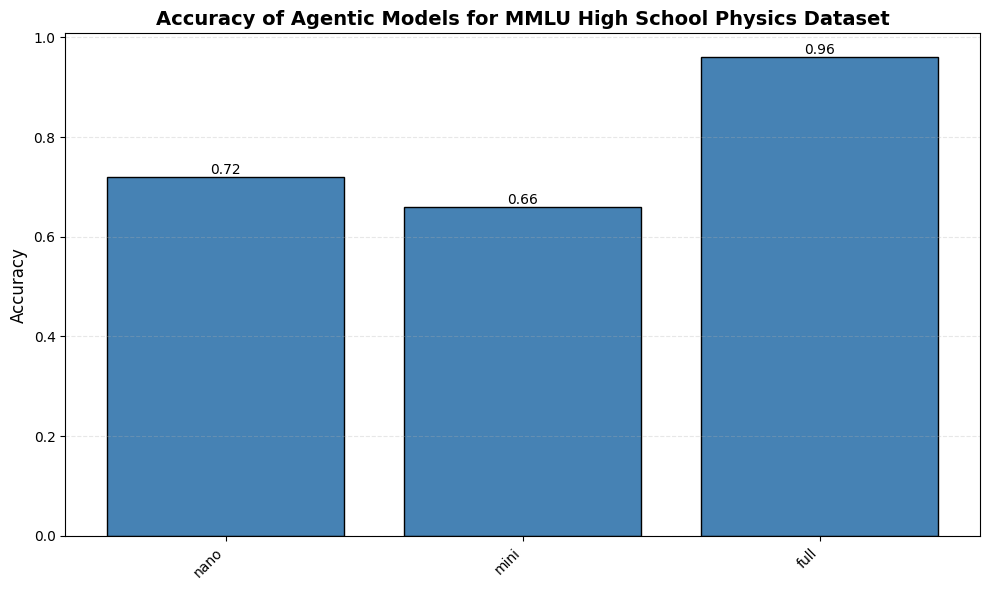

In [17]:
# Create the chart
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['model'], results_df['accuracy'], color='steelblue', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy of Agentic Models for MMLU High School Physics Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
